<a href="https://colab.research.google.com/github/RoshanPatel7580/pneumonia-detection/blob/main/trial_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RSNA Pneumonia Detection EDA**

# **Introduction**
This Kernel objective is to explore the dataset for RSNA Pneumonia Detection Challenge.

We start by exploring the DICOM data, we extract then meta information from the DICOM files and visualize the various features of the DICOM images, grouped by age, sex.

The Kernel was modified to work with stage_2 data instead of stage_1 data.

In [141]:
pip install pydicom

In [142]:
import tensorflow
tensorflow.__version__

'2.3.0'

# **Prepare the data analysis**
# **Load packages**

In [185]:
import glob, pylab, pandas as pd
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
import pydicom as dcm
%matplotlib inline 

In [186]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [187]:
IS_LOCAL = False
import os
if(IS_LOCAL):
    PATH="/content/drive/My Drive/Colab Notebooks/capstone/rsna-pneumonia-detection-challenge"
else:
    PATH="../content/drive/My Drive/Colab Notebooks/capstone/rsna-pneumonia-detection-challenge"
print(os.listdir(PATH))

['stage_2_detailed_class_info.csv', 'GCP Credits Request Link - RSNA.txt', 'stage_2_sample_submission.csv', 'stage_2_train_labels.csv', 'stage_2_test_images', '.ipynb_checkpoints', 'stage_2_train_images', 'rsna-pneumonia-detection-eda.ipynb', 'trial 2.ipynb']


### **Load the data**
**Let's load the tabular data. There are two files:**



*   **Detailed class info;**
*   **Train labels.**



In [188]:
class_info_df = pd.read_csv(PATH+'/stage_2_detailed_class_info.csv')
train_labels_df = pd.read_csv(PATH+'/stage_2_train_labels.csv') 

In [189]:
print(f"Detailed class info -  rows: {class_info_df.shape[0]}, columns: {class_info_df.shape[1]}")
print(f"Train labels -  rows: {train_labels_df.shape[0]}, columns: {train_labels_df.shape[1]}")

Detailed class info -  rows: 30227, columns: 2
Train labels -  rows: 30227, columns: 6


Let's explore the two loaded files. We will take out a 5 rows samples from each dataset.

In [148]:
class_info_df.sample(10)

,patientId,class
22105,c8281919-a362-4019-950d-86ab101c7e1f,No Lung Opacity / Not Normal
6141,4c75d5dd-63d8-4678-9f22-61340ca246db,Lung Opacity
26597,ecf17d02-12df-4cb1-b56a-b4dc014767e7,No Lung Opacity / Not Normal
28420,fb9a58ba-a25a-439f-af8a-f1383ccaeb39,No Lung Opacity / Not Normal
5637,4859f22d-14c6-4272-93d5-4dd251d93900,No Lung Opacity / Not Normal
21142,bf9b08fc-181e-46fa-9a4b-452621e5993a,Normal
26288,eab95d6c-d32d-4506-a183-4531489c904b,Normal
23866,d6aac95c-a616-4627-8575-132fec7610c8,No Lung Opacity / Not Normal
20439,bb189459-2735-44c6-a344-a645a9721dfb,Lung Opacity
5535,477cd50b-52f1-4994-871b-91cf32fa3174,No Lung Opacity / Not Normal


In [149]:
train_labels_df.sample(10)

,patientId,x,y,width,height,Target
9869,6ac3ca72-632b-47e6-9cf9-de7e0468e859,NaN,NaN,NaN,NaN,0
1672,17e0f44b-39d6-4e3f-abd0-066fd94ee6de,177.0,546.0,266.0,246.0,1
20300,ba3b13ee-0a05-4219-a45a-90eb7d91dc5d,NaN,NaN,NaN,NaN,0
29498,1b4d9ebb-644e-4602-ad36-d83cf7415be6,226.0,624.0,141.0,142.0,1
13835,8a415e6e-eab0-428d-b861-8f4b3f2f657c,NaN,NaN,NaN,NaN,0
17106,a441e005-54e9-469a-b3ce-5c94a5e42c8c,NaN,NaN,NaN,NaN,0
22387,ca670005-549e-44e8-a1cc-eb3293efb4e3,NaN,NaN,NaN,NaN,0
22790,cd928ddc-4bd4-4307-a659-4900fd70507e,491.0,448.0,290.0,367.0,1
1877,199a835e-3ce7-4efe-acd1-a9455726486b,NaN,NaN,NaN,NaN,0
12930,82e7e1d7-862f-43c7-b8d4-b2281def64fc,NaN,NaN,NaN,NaN,0


In class detailed info dataset are given the detailed information about the type of positive or negative class associated with a certain patient.

In train labels dataset are given the patient ID and the window (x min, y min, width and height of the) containing evidence of pneumonia

# Data exploration

# **Missing data**

Let's check missing information in the two datasets.

In [190]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return np.transpose(pd.concat([total, percent], axis=1, keys=['Total', 'Percent']))
missing_data(train_labels_df)

,height,width,y,x,Target,patientId
Total,20672.000000,20672.000000,20672.000000,20672.000000,0.0,0.0
Percent,68.389188,68.389188,68.389188,68.389188,0.0,0.0


In [191]:
missing_data(class_info_df)

,class,patientId
Total,0.0,0.0
Percent,0.0,0.0


The percent missing for x,y, height and width in train labels represents the percent of the target 0 (not Lung opacity).

Let's check the class distribution from class detailed info.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


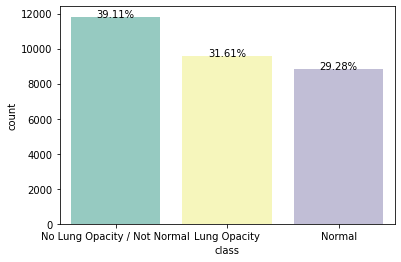

In [155]:
f, ax = plt.subplots(1,1, figsize=(6,4))
total = float(len(class_info_df))
sns.countplot(class_info_df['class'],order = class_info_df['class'].value_counts().index, palette='Set3')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

In [156]:
## more detail bifergation

In [157]:
def get_feature_distribution(data, feature):
    # Get the count for each label
    label_counts = data[feature].value_counts()

    # Get total number of samples
    total_samples = len(data)

    # Count the number of items in each class
    print("Feature: {}".format(feature))
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = int((count / total_samples) * 10000) / 100
        print("{:<30s}:   {} or {}%".format(label, count, percent))

get_feature_distribution(class_info_df, 'class')

Feature: class
No Lung Opacity / Not Normal  :   11821 or 39.1%
Lung Opacity                  :   9555 or 31.61%
Normal                        :   8851 or 29.28%


No Lung Opacity / Not Normal and Normal have together the same percent (69.077%) as the percent of missing values for target window in class details information.

In the train set, the percent of data with value for Target = 1 is therefore 30.92%

# **Merge train and class detail info data**
Let's merge now the two datasets, using Patient ID as the merge criteria

In [192]:
train_class_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')

In [193]:
train_class_df.sample(10)

,patientId,x,y,width,height,Target,class
217,040a0743-f663-4746-8224-f0e3bacc7ba5,180.0,504.0,236.0,205.0,1,Lung Opacity
22172,aaacdecb-a59f-41d9-ba6f-7e02185c2326,557.0,590.0,210.0,170.0,1,Lung Opacity
20505,a011c70e-6fda-4056-b364-8bfa67a878d0,574.0,349.0,309.0,389.0,1,Lung Opacity
18977,94c4e247-1228-4f50-b8b4-316754d5828f,696.0,405.0,202.0,280.0,1,Lung Opacity
26761,bf0e824a-1729-46a2-b1cb-13eedd6fe3d1,365.0,521.0,144.0,363.0,1,Lung Opacity
20571,a09e3acc-b0ed-4da1-9922-3d49aac9257c,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
22279,ab17c7e8-3447-431f-afcd-efec89229fe2,544.0,194.0,311.0,484.0,1,Lung Opacity
26261,bcdd92c8-2cde-4899-a6fc-46b875aaab62,147.0,438.0,233.0,255.0,1,Lung Opacity
27888,c6695240-c5ec-4839-aba6-fb9ae271f4e9,NaN,NaN,NaN,NaN,0,Normal
30449,d955b013-2d49-4afd-8218-40f5e3af8312,NaN,NaN,NaN,NaN,0,Normal


# **Target and class**
Let's plot the number of examinations for each class detected, grouped by Target value.

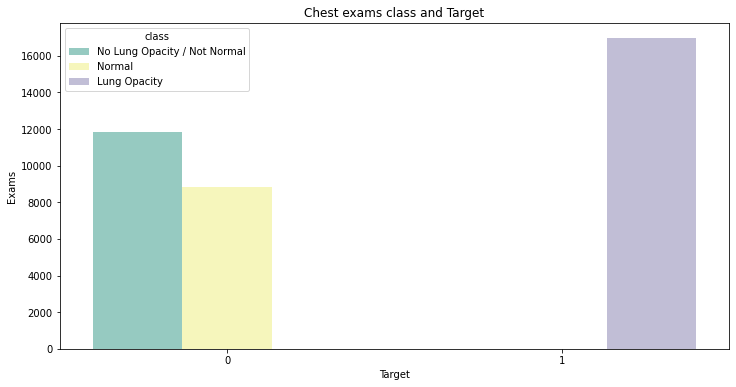

In [195]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = train_class_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Exams',hue='class',data=df, palette='Set3')
plt.title("Chest exams class and Target")
plt.show()

All chest examinations withTarget = 1 (pathology detected) associated with class: Lung Opacity.

The chest examinations with Target = 0 (no pathology detected) are either of class: Normal or class: No Lung Opacity / Not Normal

# **Explore DICOM data**

Let's read now the DICOM data in the train set. The image path is as following:

In [196]:
image_sample_path = os.listdir(PATH+'/stage_2_train_images')[:5]
print(image_sample_path)

['f694c8f4-978d-484d-be6f-e201c64a0206.dcm', 'f7314793-6863-4d4c-b090-a29308443ba7.dcm', 'f6fc2565-6f6c-4f0c-9a4f-c367ef4cacf0.dcm', 'f7d0ac07-d563-4dde-b27b-0fad32e59274.dcm', 'f7b3faca-1b1d-4428-9dc2-086106c871bf.dcm']


The files names are the patients IDs.
Let's check how many images are in the train and test folders

In [167]:
image_train_path = os.listdir(PATH+'/stage_2_train_images')
image_test_path = os.listdir(PATH+'/stage_2_test_images')
print("Number of images in train set:", len(image_train_path),"\nNumber of images in test set:", len(image_test_path))

Number of images in train set: 26684 
Number of images in test set: 3000


# **Check duplicates in train dataset**

In [169]:
print("Unique patientId in  train_class_df: ", train_class_df['patientId'].nunique())    

Unique patientId in  train_class_df:  26684


We confirmed that the number of unique patientsId are equal with the number of DICOM images in the train set.

# **DICOM meta data**

In [171]:
samplePatientID = list(train_class_df[:3].T.to_dict().values())[0]['patientId']
samplePatientID = samplePatientID+'.dcm'
dicom_file_path = os.path.join(PATH,"stage_2_train_images/",samplePatientID)
dicom_file_dataset = dcm.read_file(dicom_file_path)
dicom_file_dataset

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

# **Plot DICOM images with Target = 1**

In [197]:
def show_dicom_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()

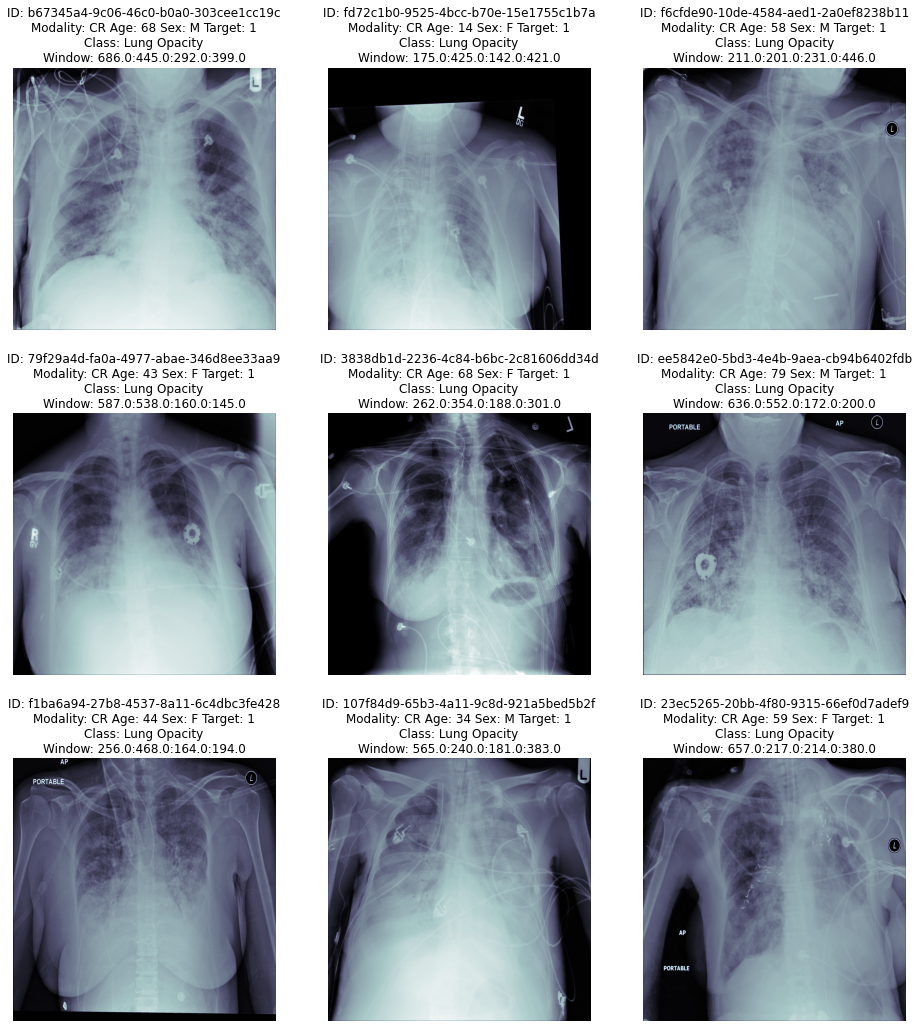

In [174]:
show_dicom_images(train_class_df[train_class_df['Target']==1].sample(9))

We would like to represent the images with the overlay boxes superposed. For this, we will need first to parse the whole dataset with Target = 1 and gather all coordinates of the windows showing a Lung Opacity on the same image. The simples method is show in [1] and we will adapt our rendering from this method

In [176]:
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], data_row['class']))
        rows = train_class_df[train_class_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="yellow",alpha = 0.1))   
    plt.show()

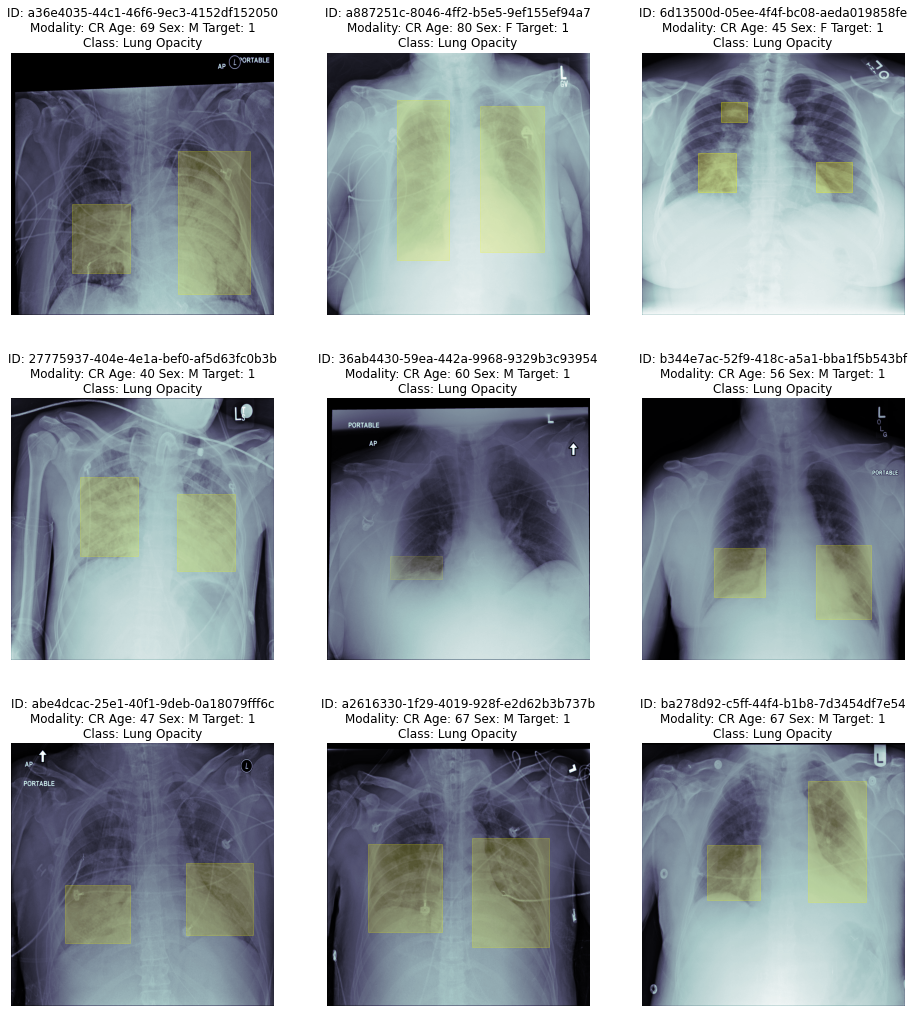

In [177]:
show_dicom_images_with_boxes(train_class_df[train_class_df['Target']==1].sample(9))

**For some of the images with Target=1, we might see multiple areas (boxes/rectangles) with Lung Opacity.**

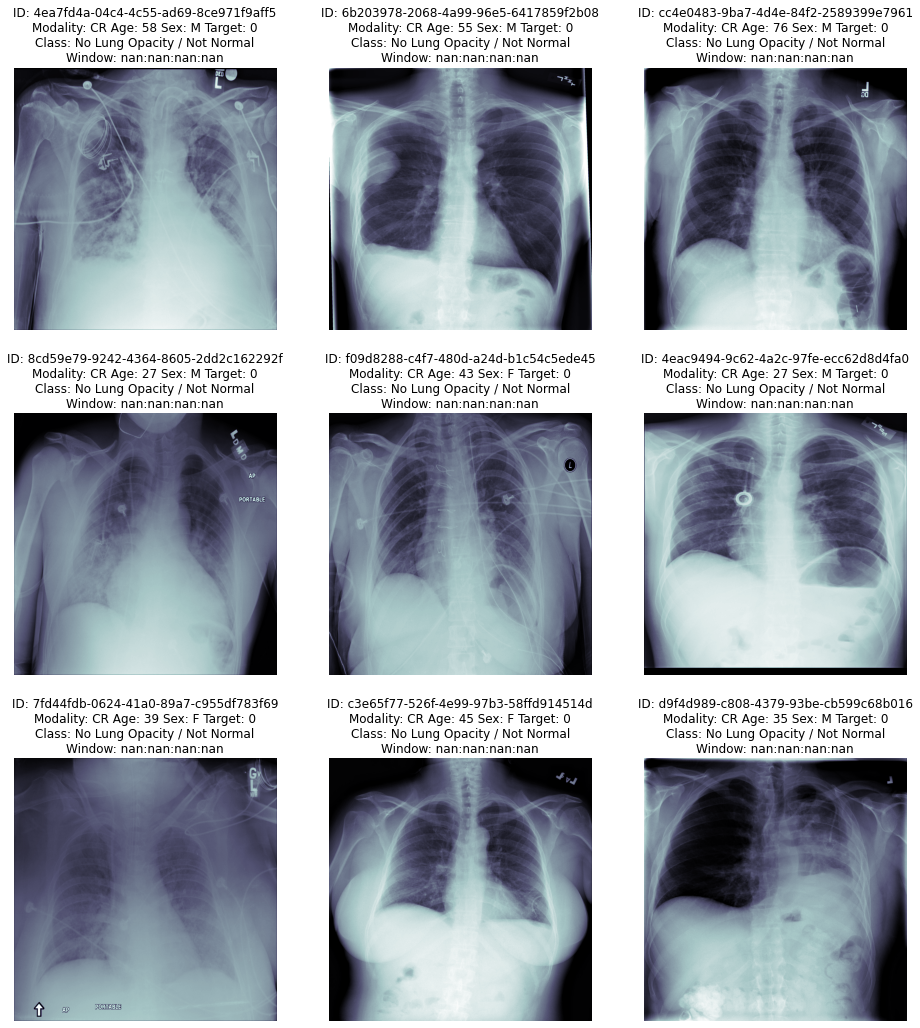

In [179]:
show_dicom_images(train_class_df[train_class_df['Target']==0].sample(9))

# **Add meta information from DICOM data**

## **Train data**

In [181]:
vars = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

def process_dicom_data(data_df, data_path):
    for var in vars:
        data_df[var] = None
    image_names = os.listdir(PATH+data_path)
    for i, img_name in tqdm_notebook(enumerate(image_names)):
        imagePath = os.path.join(PATH,data_path,img_name)
        data_row_img_data = dcm.read_file(imagePath)
        idx = (data_df['patientId']==data_row_img_data.PatientID)
        data_df.loc[idx,'Modality'] = data_row_img_data.Modality
        data_df.loc[idx,'PatientAge'] = pd.to_numeric(data_row_img_data.PatientAge)
        data_df.loc[idx,'PatientSex'] = data_row_img_data.PatientSex
        data_df.loc[idx,'BodyPartExamined'] = data_row_img_data.BodyPartExamined
        data_df.loc[idx,'ViewPosition'] = data_row_img_data.ViewPosition
        data_df.loc[idx,'ConversionType'] = data_row_img_data.ConversionType
        data_df.loc[idx,'Rows'] = data_row_img_data.Rows
        data_df.loc[idx,'Columns'] = data_row_img_data.Columns  
        data_df.loc[idx,'PixelSpacing'] = str.format("{:4.3f}",data_row_img_data.PixelSpacing[0]) 

In [182]:
process_dicom_data(train_class_df,'stage_2_train_images/')

FileNotFoundError: ignored

Test **data**

In [183]:
test_class_df = pd.read_csv(PATH+'/stage_2_sample_submission.csv')

In [184]:
test_class_df = test_class_df.drop('PredictionString',1)
process_dicom_data(test_class_df,'stage_2_test_images/')

FileNotFoundError: ignored